In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import cmocean

In [2]:
# constant declarations
#lat1 < lat2
lat1 = -45
lat2 = 45

#lon1 < lon2
lon1 = 0
lon2 = 360

lat_lims = [lat1,lat2]
lon_lims = [lon1,lon2]

#pressure level and month to access
pressure_level = 850
wind_pressure_level = 1000
#month = 1
season = 1


#variable files on disk
q_file = r'C:\Users\Jakidxav\Desktop\work_hartmann\erai_monthly\q\q.nc'
u_file = r'C:\Users\Jakidxav\Desktop\work_hartmann\erai_monthly\u\u.nc'
v_file = r'C:\Users\Jakidxav\Desktop\work_hartmann\erai_monthly\v\v.nc'

#constant accessor lists
month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
season_list = ['DJF', 'MAM', 'JJA', 'SON']
lon_list = [90, 120, 150, 180, -150, -120, -90, -60, -30, 0, 30, 60, 90]
lat_list = [-30, 0, 30]


#for plotting
central_lon = -90

proj = ccrs.PlateCarree(central_longitude=central_lon)
trans = ccrs.PlateCarree()
stride = 3
colormap = cmocean.cm.balance
colorbar_label = r"$g kg^{-1}$"
contours = 50

left_title = r'q at '+str(pressure_level)
left_title_wind = r'q at '+str(pressure_level)+'mb, u,v at '+str(wind_pressure_level)+'mb'
#right_title = month_list[month-1].upper()
right_title = season_list[season-1]

#figure_name = 'q_'+str(pressure_level)+'_'+month_list[month-1]+'_mean.pdf'
figure_name = 'q_'+str(pressure_level)+'_'+season_list[season-1]+'_mean.pdf'
#figure_name_wind = 'q_'+str(pressure_level)+'_u_v_'+str(wind_pressure_level)+'_'+month_list[month-1]+'_mean.pdf'
figure_name_wind = 'q_'+str(pressure_level)+'_u_v_'+str(wind_pressure_level)+'_'+season_list[season-1]+'_mean.pdf'

# Data Import

In [3]:
#read in data files
u_data = nc.Dataset(u_file)
v_data = nc.Dataset(v_file)
q_data = nc.Dataset(q_file)

In [4]:
#extract variables
u = u_data.variables['u'][:]
v = v_data.variables['v'][:]
q = q_data.variables['q'][:]

In [5]:
lon  = q_data.variables['longitude'][:]
lat  = q_data.variables['latitude'][:]
dumb_time = q_data.variables['time'][:]
p = q_data.variables['levelist'][:]

In [6]:
#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

In [7]:
#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

lonidx = (lon >=lon_lims[0] ) & (lon <=lon_lims[1] )

#take only january
#timidx  = (time.month == 1)
#take January, February, and December
timidx  = np.logical_or(time.month <= 2, time.month > 11)

pidx = (p==pressure_level)
wind_pidx = (p==wind_pressure_level)

In [8]:
#subset data based on desired month
u_time = u[timidx]
v_time = v[timidx]
q_time = q[timidx]

In [9]:
#subset data based on desired pressure level
u_time_p = u_time[:, wind_pidx, :, :]
v_time_p = v_time[:, wind_pidx, :, :]
q_time_p = q_time[:, pidx, :, :]

In [10]:
#subset data based only on lat/lon grid wanted
u_time_p_lat = u_time_p[:, :, latidx, :]
v_time_p_lat = v_time_p[:, :, latidx, :]
q_time_p_lat = q_time_p[:, :, latidx, :]

In [11]:
#average over (collapse) the time dimension
u_month_avg = np.mean(u_time_p_lat, axis=0)
v_month_avg = np.mean(v_time_p_lat, axis=0)
q_month_avg = np.mean(q_time_p_lat, axis=0)

wind_x = u_month_avg[0]
wind_y = v_month_avg[0]
q = q_month_avg[0]

In [12]:
#multiply by 1000 to get units of g kg^-1
q = q * 1000

## q MAP

In [17]:
def plot_field(projection, central_lon, x, y, field, windx, windy, contours, transform, colormap, wind_vectors, strid, lon_list, lat_list,
               left_title, left_title_wind, right_title, figure_name, figure_name_wind, save_fig):
    fig = plt.figure(figsize=(14, 28))
    ax = plt.axes(projection=projection)


    Norm = mpl.colors.Normalize(vmin=-14.5, vmax=14.5)
    plt1 = ax.contourf(x, y, field, contours, transform=trans, cmap=colormap, norm=Norm)
    #plt.colorbar(shrink=0.1, mappable=plt1)
    cbar = fig.colorbar(plt1, orientation='vertical', shrink=0.1)
    cbar.set_label(colorbar_label)
    
    if(wind_vectors==True):
        q = ax.quiver(x[::stride], y[::stride], wind_x[::stride, ::stride], wind_y[::stride, ::stride],
             minshaft=2, pivot='tip', transform=trans)
        
    ax.coastlines()

    ax.set_xticks(lon_list, crs=trans)
    ax.set_xticklabels(lon_list, weight='bold')
    ax.set_yticks(lat_list, crs=trans)
    ax.set_yticklabels(lat_list, weight='bold')
    ax.yaxis.tick_left()
    
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid(linewidth=2, color='black', alpha = 0.5)
    
    if(wind_vectors==True):
        ax.set_title(left_title_wind, loc='left', weight='semibold', size='medium')
    else:
        ax.set_title(left_title, loc='left', weight='semibold', size='medium')
    
    ax.set_title(right_title, loc='right', weight='semibold', size='medium')

    if(save_fig==True):
        if(wind_vectors==True):
            plt.savefig(figure_name_wind, format='pdf')
        else:
            plt.savefig(figure_name, format='pdf')
            
    plt.tight_layout()
    plt.show()

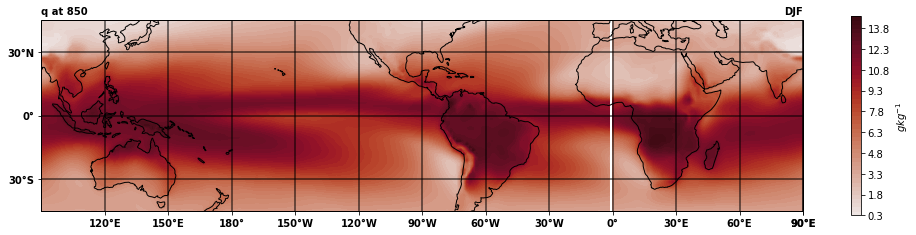

In [20]:
#without wind barbs
plot_field(proj, central_lon, lon[lonidx], lat[latidx], q, wind_x, wind_y, contours, trans, colormap, False, stride, lon_list, lat_list,
               left_title, left_title_wind, right_title, figure_name, figure_name_wind, False)

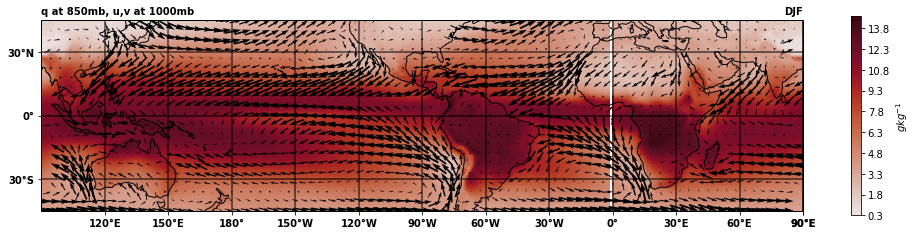

In [21]:
#with wind barbs
plot_field(proj, central_lon, lon[lonidx], lat[latidx], q, wind_x, wind_y, contours, trans, colormap, True, stride, lon_list, lat_list,
               left_title, left_title_wind, right_title, figure_name, figure_name_wind, False

In [16]:
print(np.max(q))
print(np.min(q))

14.41401286671186
0.5765077125435244
